In [1]:
from jupyter_client import find_connection_file
connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-v2-100972wwVp0QuO89Dw.json


In [2]:
# Plotting related
import os
import sys

sys.tracebacklimit = 0
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", None)
pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve
from sklearn.cluster import KMeans
from math import log

import importlib
# Constants for this project
import constants
from constants import *


import papermill as pm
import shutil
shutil.copy('constants.py', 'export/')
from IPython.display import Markdown as md

# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")


sys.tracebacklimit = 0
def exception_handler(exception_type, exception, traceback):
    # All your trace are belong to us!
    # your format
    print(f"{exception_type.__name__}, {exception}")

sys.excepthook = exception_handler

In [3]:
# Define auxilary functions
def get_dir_by_name(dir_name):
    # Define the starting directory
    current_dir = os.getcwd()

    # Traverse up the directory tree until we find a directory named "data"
    while current_dir != "/":
        if dir_name in os.listdir(current_dir):
            data_dir = os.path.join(current_dir, dir_name)
            return data_dir
        current_dir = os.path.dirname(current_dir)
    else:
        print(f"Directory {dir_name} not found in the parent directories.")
        raise (Exception())


def remove_duplicate_accessions(dataset, immage_col, uid_col):
    '''Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276.
    Average the IMMAGE, since all else is the same'''
    first_uid = dataset.iloc[0][uid_col]
    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    if len(accessions) > 1:
        # print(f"Multiple accession detected, Collapsing by averaging on IMMAGE value")
        dataset = dataset.groupby(uid_col, as_index=False).agg({immage_col: "mean", **{col: "first" for col in dataset.columns if col not in [uid_col, immage_col]},})

    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    assert len(accessions) == 1

    return dataset

def get_threshold_from_probability(prob, intercept, slope):
    return -1 * (log(1 / prob - 1) + intercept) / slope

def plot_response(data, dataset_name, strain, features=""):
    custom_palette = {"Non-Responders": "orange", "Responders": "#3498db"}
    if len(features) == 1:
        col_name = features[0]
        # Plot sorted feature values vs Index on the second subplot
        sorted_data = data.sort_values(col_name, ignore_index=True).reset_index()
        sns.scatterplot(
            data=sorted_data, x="index", y=col_name, hue="Label text", palette=custom_palette
        )
        
        plt.set_title(f"Sorted {col_name} vs Index")

    if len(features) == 2:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # Creates a figure with two side-by-side subplots
        col_name_1 = features[0]
        col_name_2 = features[1]

        sorted_data = data.sort_values(col_name_1, ignore_index=True).reset_index()
        sns.scatterplot(
            ax=axs[0], data=sorted_data, x="index", y=col_name_1, hue="Label text", palette=custom_palette
        )
        axs[0].set_title(f"Sorted {col_name_1} vs Index")

        sorted_data = data.sort_values(col_name_2, ignore_index=True).reset_index()
        sns.scatterplot(
            ax=axs[1], data=sorted_data, x="index", y=col_name_2, hue="Label text", palette=custom_palette
        )
        axs[1].set_title(f"Sorted {col_name_2} vs Index")

    fig.suptitle(f"Response distribution: {dataset_name} {strain}")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

def get_classifier_stats_prob(data, prob_column, prob_threshold):
    # Global measures (entire dataset)
    optimal_pred = data[prob_column].apply(lambda x: 1 if x >= prob_threshold else 0)
    test_accuracy = accuracy_score(data["y"], optimal_pred)
    # Performance above the prob_threshold
    y_over_thr = data.loc[data[prob_column] >= prob_threshold, ["y"]]
    non_response_rate_over_thr = y_over_thr.mean().y
    y_under_thr = data.loc[data[prob_column] < prob_threshold, ["y"]]
    non_response_rate_under_thr = y_under_thr.mean().y
    return non_response_rate_over_thr, non_response_rate_under_thr

In [4]:
def analyze_dataset(dataset, P):
    # These parameters are overridden by papermill
    dataset_name = P["dataset_name"]
    bAdjustMFC = P["bAdjustMFC"]
    strain_index = P["strain_index"]
    day = P["day"]
    day0  = P["day0"]
    strains = P["strains"]
    strain = P["strain"]
    
    if len(strains) > 1:
        dataset = dataset.loc[dataset[strain_col] == strain].reset_index(drop=True)

    # Discard seroprotected subjects based on HAI > 40 threshold)
    if bDiscardSeroprotected:
        day0_mask = dataset[day_col] == day0
        threshold_mask = dataset[response_col]> HAI_threshold

        # Get a list of all protected patients
        serprotected_subjects = dataset.loc[(day0_mask) & (threshold_mask)][uid_col].unique()
        # keep only patients not in the serprotected_subjects list
        dataset = dataset.loc[~dataset[uid_col].isin(serprotected_subjects)]
        subjects_left = dataset[uid_col].unique()
        # print(f"Discarding {len(serprotected_subjects)} seroprotected subjects")
        # print(f"Subjects left: N={len(subjects_left)}")

    # Pivot the dataset such that different days' samples appear in their own columns, witn NaN where there are missing samples
    t = dataset[[dataset_col, uid_col, age_col, immage_col,accesion_col , day_col, response_col]]
    pivot_t = t.pivot_table(index=uid_col, columns=day_col, values=response_col, aggfunc='first')
    age_t = dataset[['uid', 'Age']].drop_duplicates()

    # Average IMMAGE values across geo_accessions (if they exist) and merge
    immage_t = t.groupby('uid')[immage_col].mean()
    tmp_t = age_t.merge(immage_t, on='uid', how='left').drop_duplicates()
    pivot_t = tmp_t.merge(pivot_t, on='uid', how='left')

    # Reset index to make uid a column again
    pivot_t.reset_index(inplace=True, drop=True)

    # Remove the name of the columns and index name
    pivot_t.columns.name = None
    pivot_t.index.name = None

    # Currently only used by AdjustMFC branch. TODO: convert the "regular" branch to use it too
    pivot_dataset = pivot_t

    # Use adjusted MFC (HAI) as per John Tsang
    cluster_col = day0
    if bAdjustMFC:
        print("Preprocessing dataset, computing adjusted FC")
        metadata = pd.DataFrame(dataset_day_dicts_for_adjFC)
        days = metadata[metadata[dataset_col] == dataset_name]["Days"].iloc[0]
        sampleDay = [x for x in days if "D0" not in x][0]
        day0 = [x for x in days if "D0" in x][0]
        cluster_col = day0

        # Pivot the table to have a column per day
        dataset = pivot_dataset[[uid_col, immage_col, age_col, day0, sampleDay]]
        dataset = dataset.loc[(~pivot_t[day0].isna()) & (~pivot_t[sampleDay].isna())] ;
        dataset["FC"] = dataset[sampleDay]/dataset[day0]

        # Remove outliers
        mean = dataset[day0].mean()
        std = dataset[day0].std()
        threshold = 3 * std
        dataset = dataset[(dataset[day0] >= mean - threshold) & (dataset[day0] <= mean + threshold)]

        # Bin subjects into 2-3 bins using k-means clustering
        kmeans = KMeans(n_clusters=3, random_state=0)
        dataset['Cluster'] = kmeans.fit_predict(dataset[[cluster_col]])

        def normalize(x):
            return (x - x.median()) / x.std()

        # Normalize the FC within each bin to obtain the adjFC
        dataset['adjFC'] = dataset.groupby('Cluster')["FC"].transform(normalize)

        # Take relevant columns only
        data = dataset[[immage_col, 'adjFC', age_col, cluster_col, "Cluster"]].rename(columns={'adjFC': response_col}).dropna()
        # data.groupby("Cluster").count()

    else: # bAdjustMFC == False
        # If not computing adjMFC, take a specific strain from the given post-vaccine day & assay
        day_mask = dataset[day_col] == day
        dataset = dataset.loc[(day_mask)].reset_index(drop=True)

        dataset = remove_duplicate_accessions(dataset, immage_col, uid_col)

        # Take relevant columns only
        data = dataset[[immage_col, response_col, age_col]]

    # Keep older subjects only, since that's what's actually interesting, and may show IMMAGE's advantage
    if bOlderOnly == True:
        young_subjects = data.loc[data[age_col] < age_threshlod]
        data = data.loc[data[age_col] >= age_threshlod]
        if len(data) == 0:
            raise(Exception("No subjects over the age of {age_threshlod}. Exiting."))
        # print(f"Discarding {len(young_subjects)} seroprotected subjects")
        # print(f"Subjects left: N={len(data)}")


    #### Dataset & Strain info
    age_restrict_str = f", Subjects over the age of {age_threshlod}" if bOlderOnly else ""
    day_str = "Adjusted MFC" if bAdjustMFC else f"day: {day}"

    # print(f"""### Analysis for dataset: {dataset_name}, strain: {strain}, {day_str}{age_restrict_str}""")

    data.reset_index(inplace=True, drop=True)

    # Get a boolean map of sub and super threshold values
    low_response_thr = data[[response_col]].quantile(q=0.3).item()

    # Generate labels
    # Note that we define y=1 for all responses <= 30th percentile (and not <)
    # Also note that we defined y=1 as *non* responders, since later on that's what we'll care about detecting
    data["y"] = data[response_col].apply(lambda x: 1 if x <= low_response_thr else 0)

    # Add a text label for plot legends
    data["Label text"] = data["y"].apply(lambda x: "Responders" if x == 0 else "Non-Responders")


  
    # IMMAGE
    plot_response(data, dataset_name, strain, features=[immage_col, age_col])
  



In [9]:
def analyze_all_datasets(datasets, metadata):
    accumulated_results = pd.DataFrame()
    for dataset_name in metadata[dataset_col].unique():
            curr_metadata = metadata.loc[metadata[dataset_col] == dataset_name]
            dataset = datasets.loc[datasets[dataset_col] == dataset_name]
            print(dataset_name)
            day = [x for x in curr_metadata["Days"].iloc[0] if "D0" not in x][0]
            strains = dataset.loc[dataset[day_col] == day][strain_col].unique()
            if len(strains) < 1:
                 strains = ["single strain - data missing"]
            if len(strains) > 1:
                strains = list(set(strains) - set(["Influenza"])) # denotes an MFC calculation in the original dataset
            # print(strains)
            for strain_index in range(len(strains)):
                strain_name = strains[strain_index].replace("/", "_").replace(" ", "_")
                # print(f'exporting {dataset_name}, strain no. {strain_index}: {strain_name}, day: {day}')
                # Define parameters for curr_metadata and strain
                day0 = [x for x in curr_metadata["Days"].iloc[0] if "D0" in x][0]
                P = {
                    "bAdjustMFC": bAdjustMFC,
                    "dataset_name": dataset_name,
                    "strain_index": strain_index,
                    "strain": strains[strain_index],
                    "strains": strains,
                    "day":  day,
                    "day0":  day0,
                }
                try:
                    tmp_dict = {
                        dataset_col: dataset_name,
                        strain_col: strain_name,
                        strain_index_col: strain_index,
                        day_col: "AdjMFC" if bAdjustMFC else f"{day}",
                        "bAdjustMFC" :  bAdjustMFC,
                    }
                    analyze_dataset(dataset, P)
                except Exception as e:
                    print (f"Caught exception when runnnig {dataset_name}")
                    raise(e)



Analysis parameters: discarding serprotected subjects: False
GSE125921.SDY1529
Preprocessing dataset, computing adjusted FC


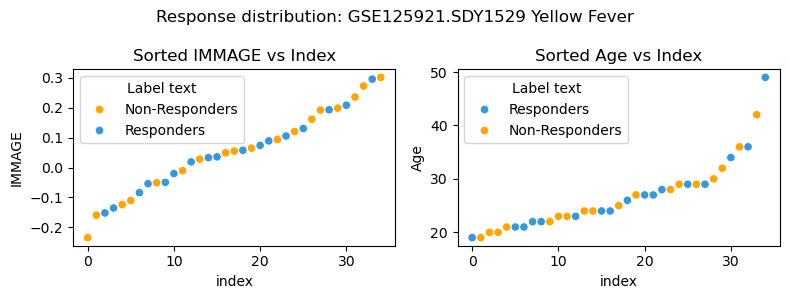

GSE13699.SDY1289
Preprocessing dataset, computing adjusted FC


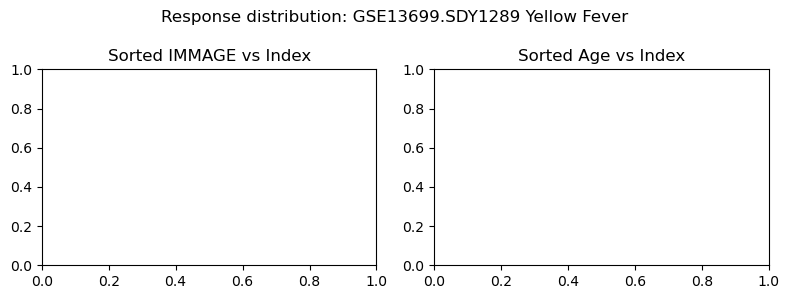

GSE169159
Preprocessing dataset, computing adjusted FC


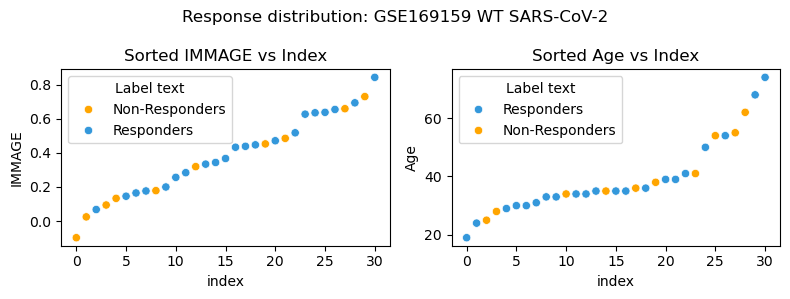

GSE41080.SDY212
Preprocessing dataset, computing adjusted FC


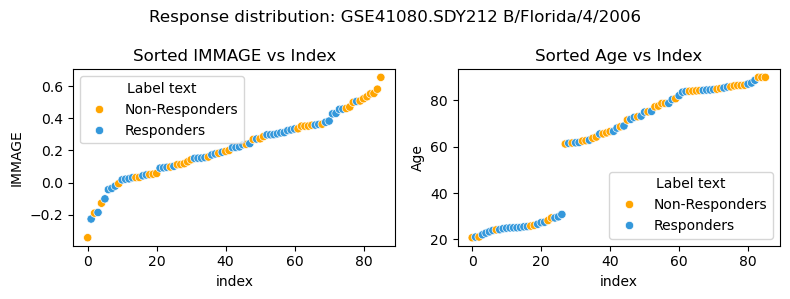

Preprocessing dataset, computing adjusted FC


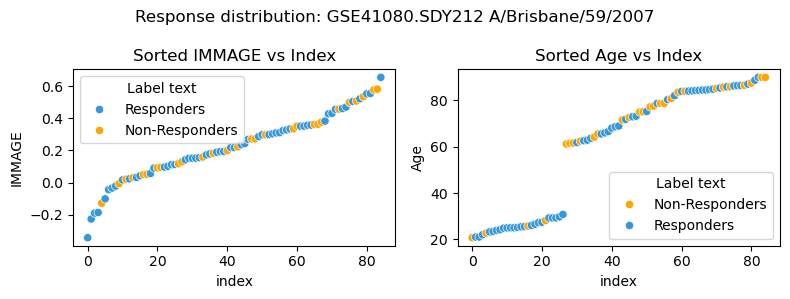

Preprocessing dataset, computing adjusted FC


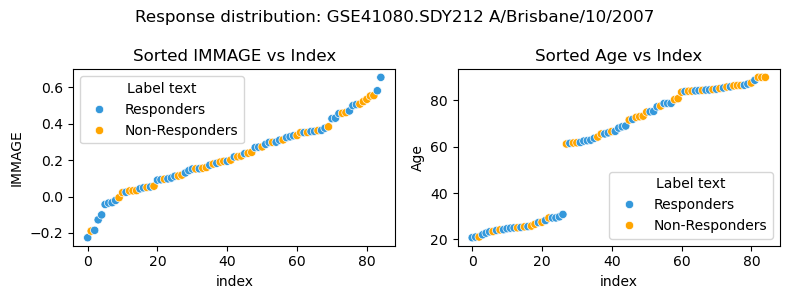

GSE48018.SDY1276
Preprocessing dataset, computing adjusted FC


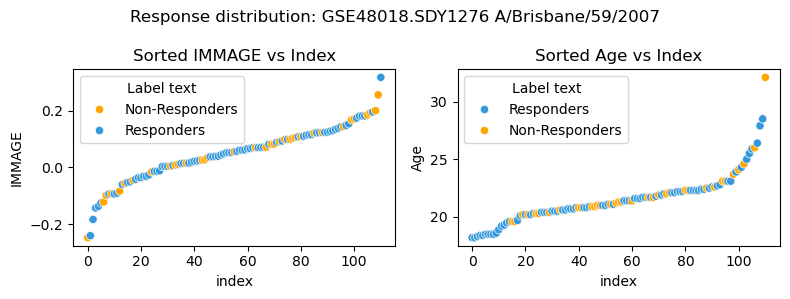

Preprocessing dataset, computing adjusted FC


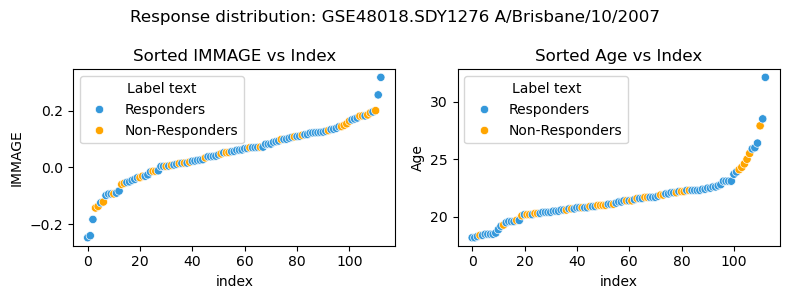

Preprocessing dataset, computing adjusted FC


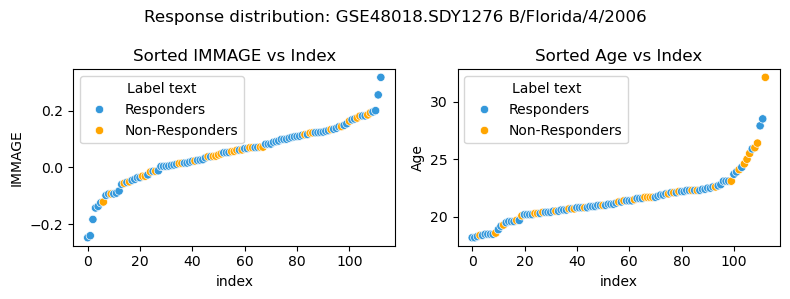

GSE48023.SDY1276
Preprocessing dataset, computing adjusted FC


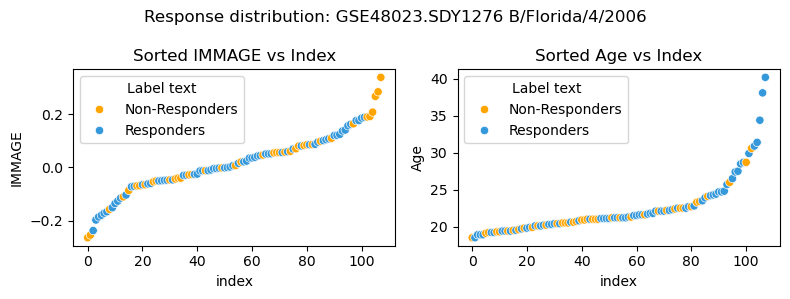

Preprocessing dataset, computing adjusted FC


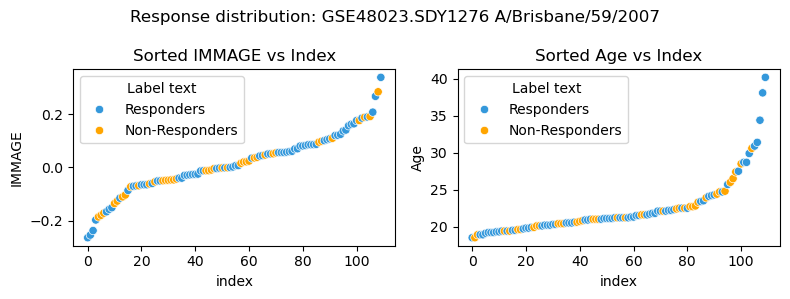

Preprocessing dataset, computing adjusted FC


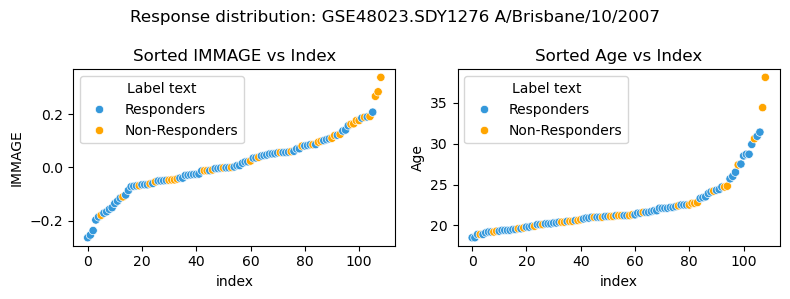

GSE52245.SDY1260
Preprocessing dataset, computing adjusted FC


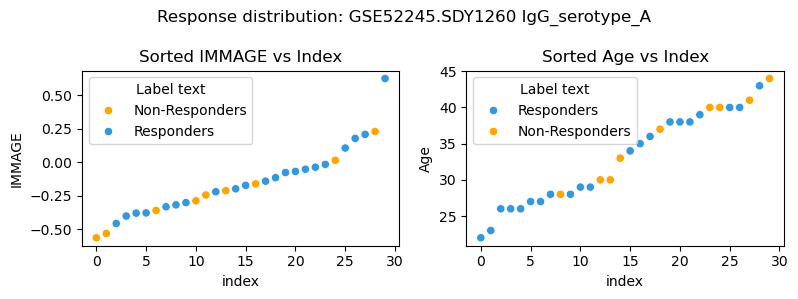

Preprocessing dataset, computing adjusted FC


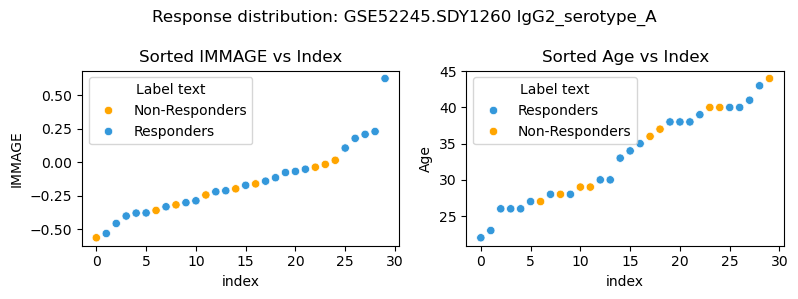

Preprocessing dataset, computing adjusted FC


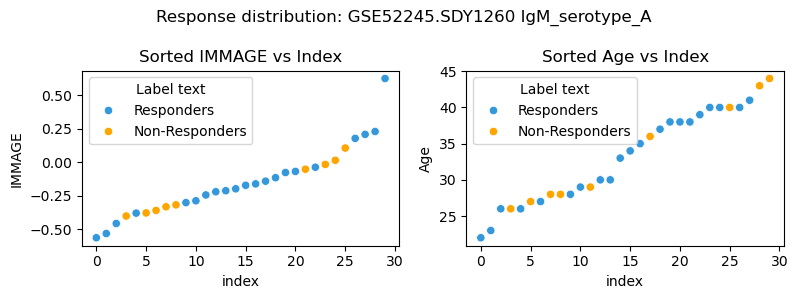

Preprocessing dataset, computing adjusted FC


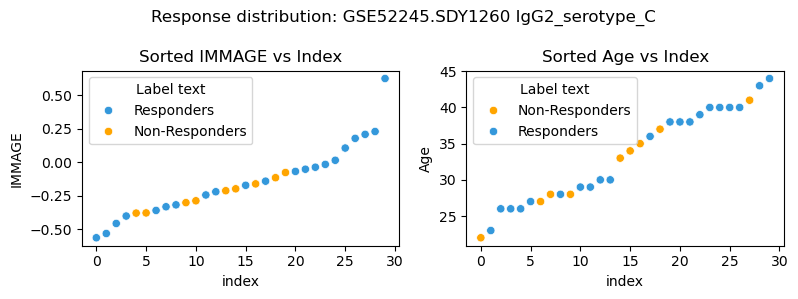

Preprocessing dataset, computing adjusted FC


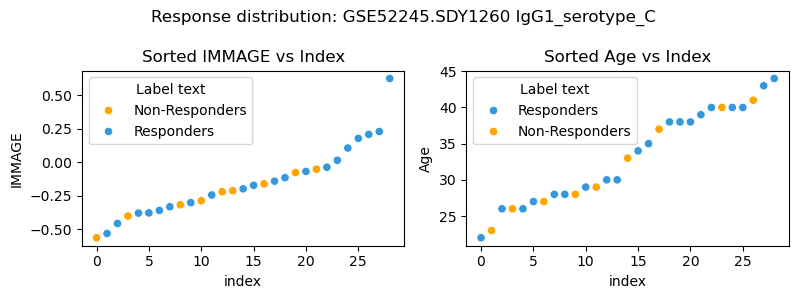

Preprocessing dataset, computing adjusted FC


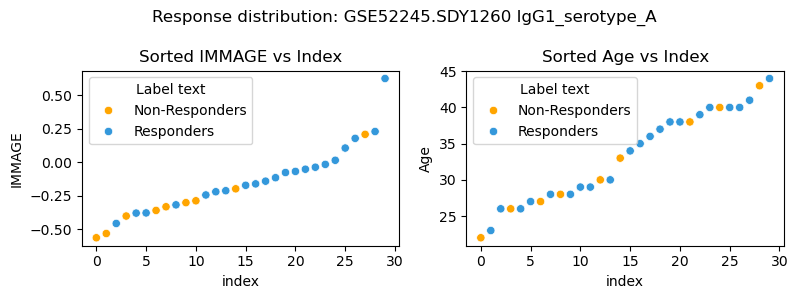

Preprocessing dataset, computing adjusted FC


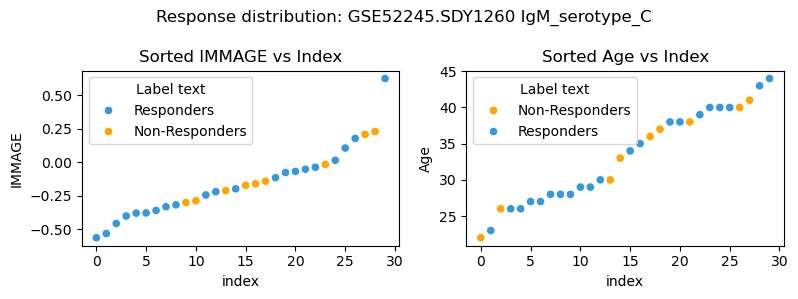

Preprocessing dataset, computing adjusted FC


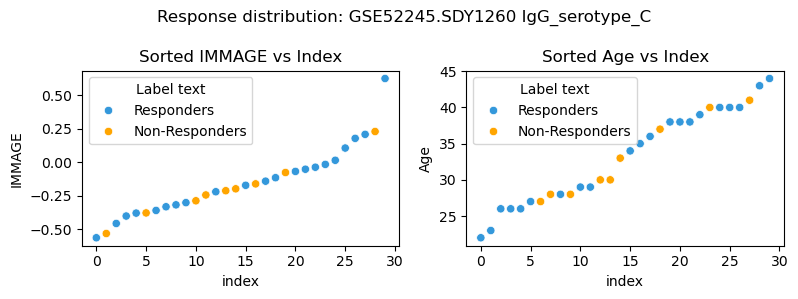

GSE59635.SDY63
Preprocessing dataset, computing adjusted FC


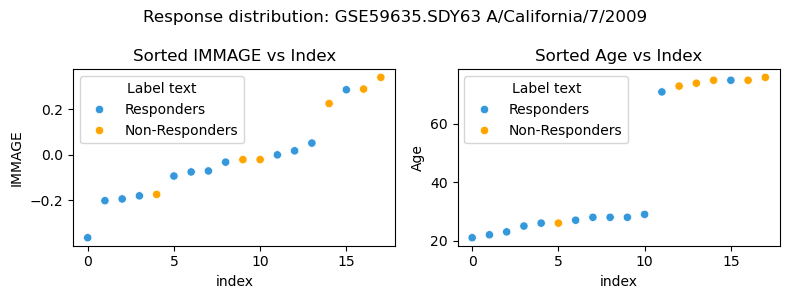

Preprocessing dataset, computing adjusted FC


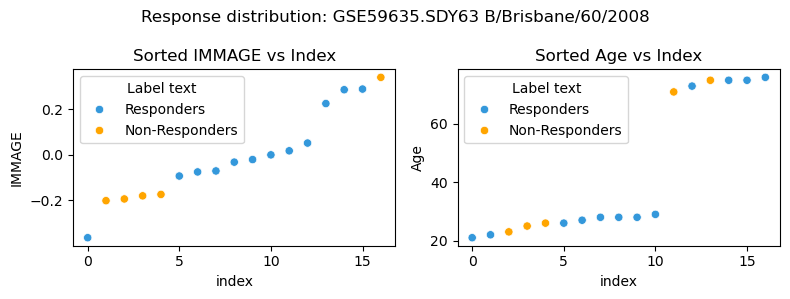

Preprocessing dataset, computing adjusted FC


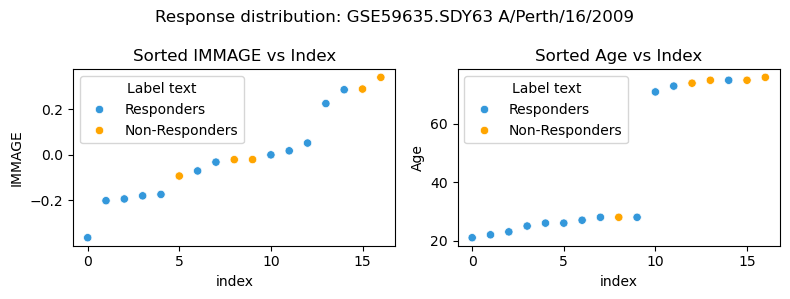

GSE59654.SDY180
Preprocessing dataset, computing adjusted FC


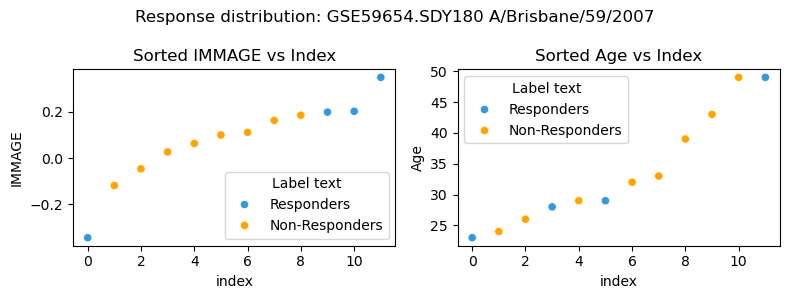

Preprocessing dataset, computing adjusted FC


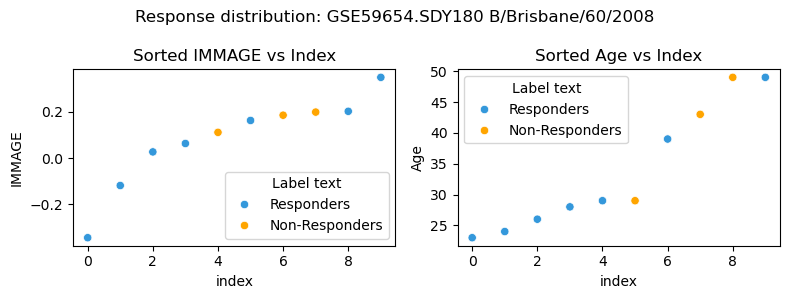

Preprocessing dataset, computing adjusted FC


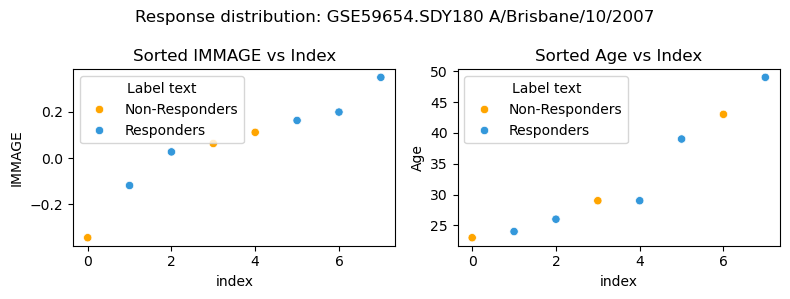

GSE59654.SDY404
Preprocessing dataset, computing adjusted FC


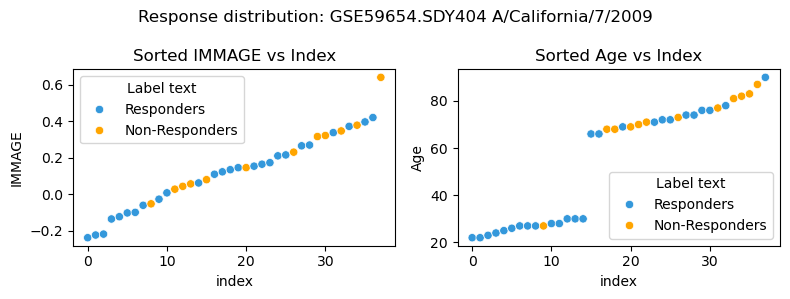

Preprocessing dataset, computing adjusted FC


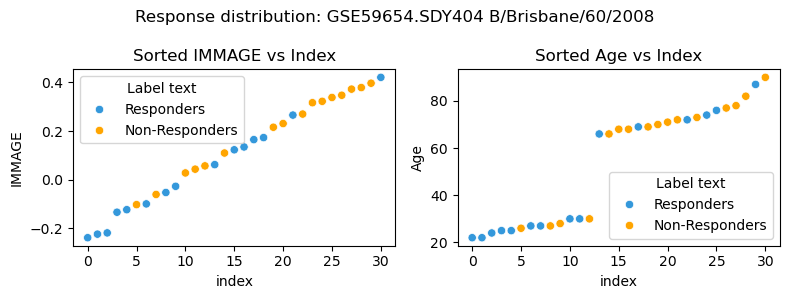

Preprocessing dataset, computing adjusted FC


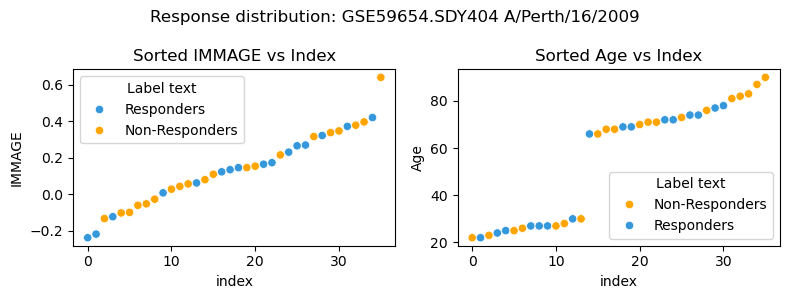

GSE59654.SDY520
Preprocessing dataset, computing adjusted FC


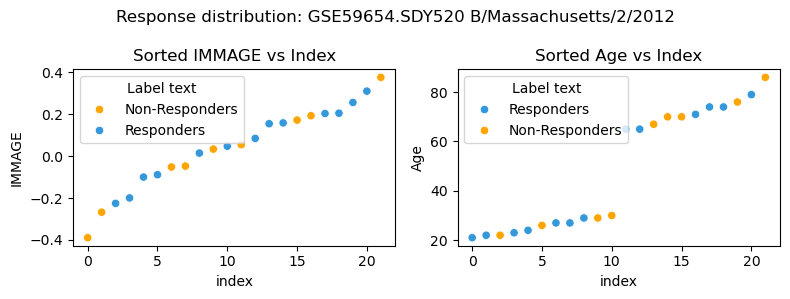

Preprocessing dataset, computing adjusted FC


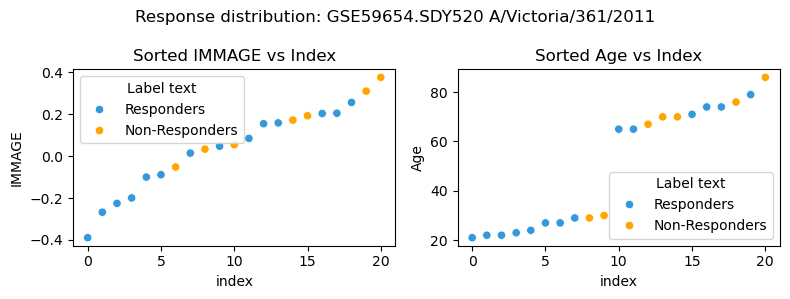

Preprocessing dataset, computing adjusted FC


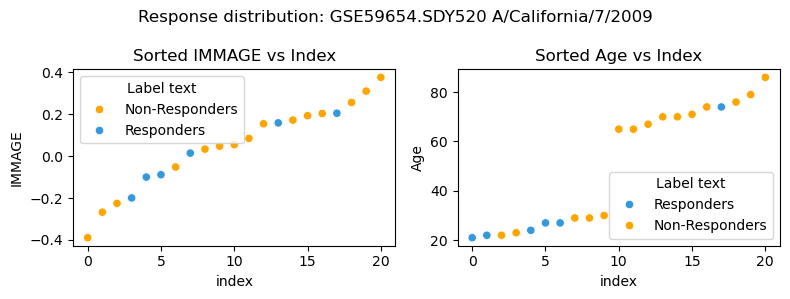

Preprocessing dataset, computing adjusted FC


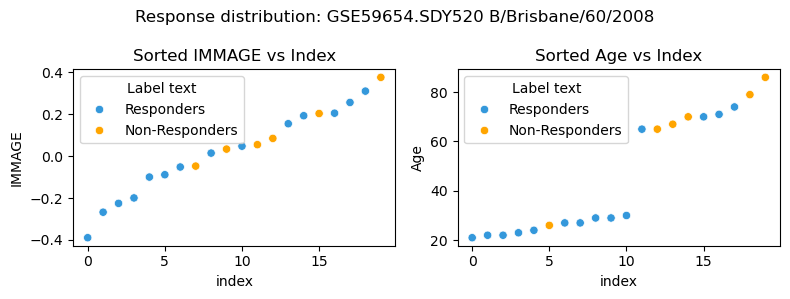

GSE59743.SDY400
Preprocessing dataset, computing adjusted FC


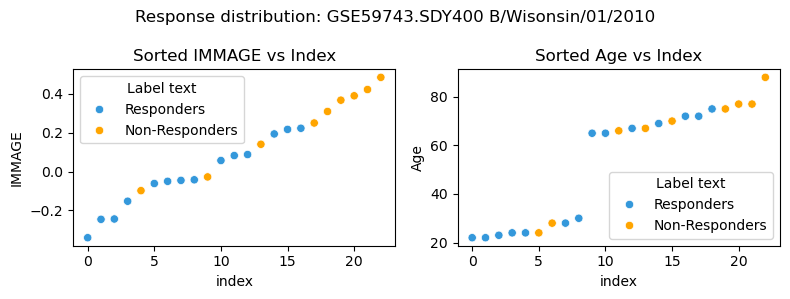

Preprocessing dataset, computing adjusted FC


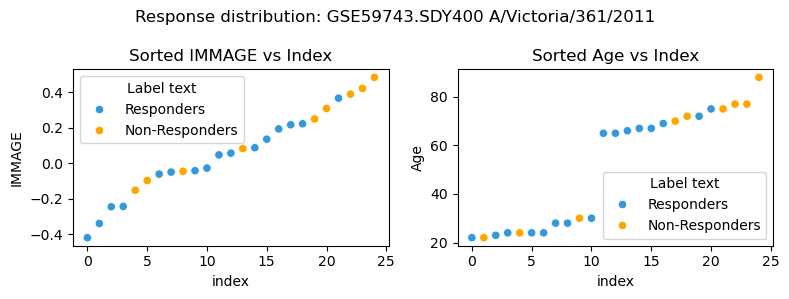

Preprocessing dataset, computing adjusted FC


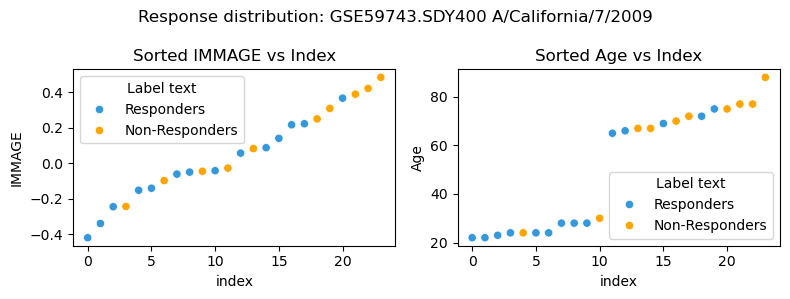

GSE79396.SDY984
Preprocessing dataset, computing adjusted FC


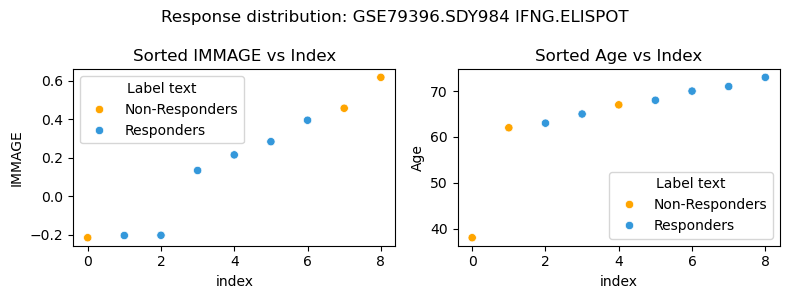

SDY1325
Preprocessing dataset, computing adjusted FC


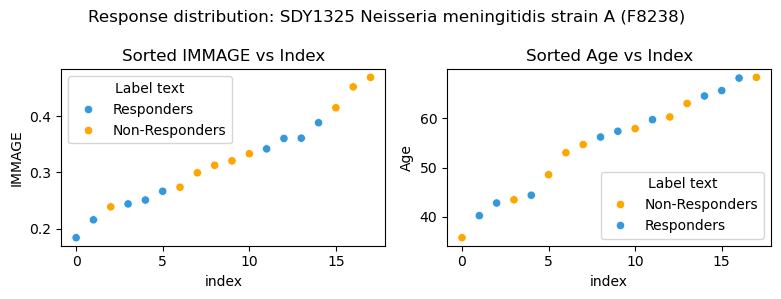

Preprocessing dataset, computing adjusted FC


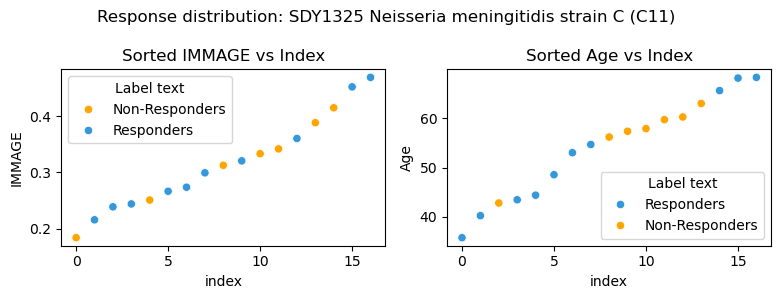

SDY296
Preprocessing dataset, computing adjusted FC


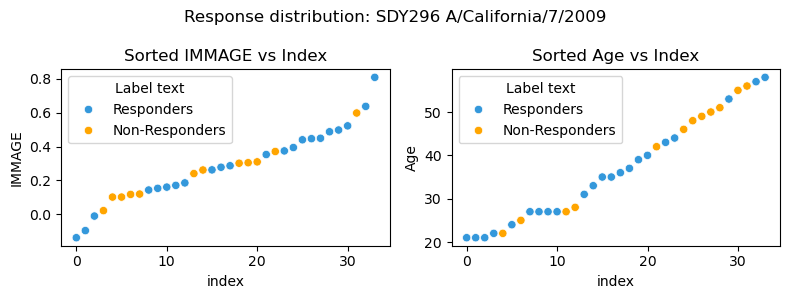

Preprocessing dataset, computing adjusted FC


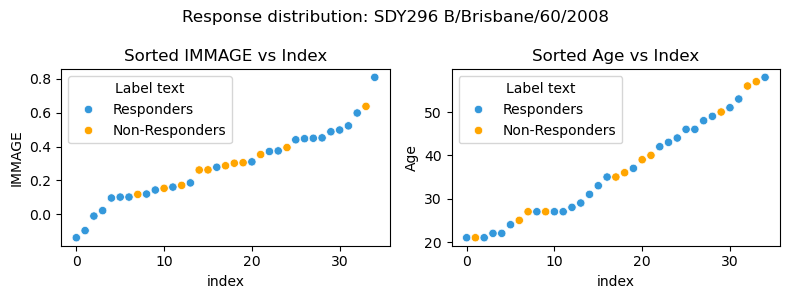

Preprocessing dataset, computing adjusted FC


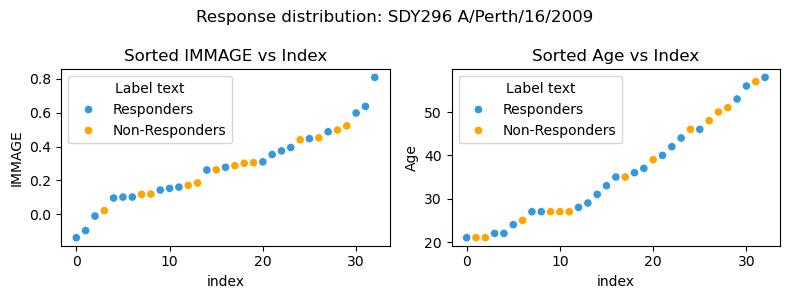

SDY67
Preprocessing dataset, computing adjusted FC


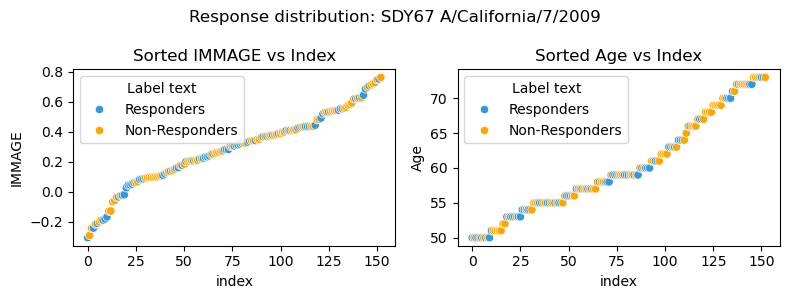

Preprocessing dataset, computing adjusted FC


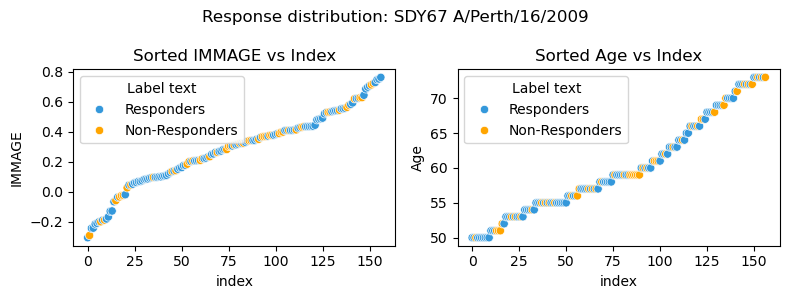

In [10]:

# def main():

# Read in Data and drop missing values
data_dir = get_dir_by_name("data")
df = pd.read_csv(os.path.join(data_dir, "../data/all_vaccines.csv"))
datasets = df.dropna(subset=[immage_col, age_col, dataset_col, uid_col, day_col, response_col])
dataset_names = datasets[dataset_col].unique()
# Get the info for all influenza datasets, excluding some.
influenza_df = pd.DataFrame(influenza_dicts)
all_sets_df = pd.DataFrame(dataset_day_dicts_for_adjFC)

if bInfluenza:
    # Get the info for all influenza datasets, excluding some.
    metadata = influenza_df
    dataset_names = metadata[dataset_col].unique().astype(str)
    dataset_names = list(set(dataset_names) - set(exclude_datasets))
elif bNonInfluenza:
    metadata = all_sets_df
    dataset_names = all_sets_df[dataset_col].unique().astype(str)
    dataset_names = list(set(dataset_names) - set(influenza_df[dataset_col]) - set(exclude_datasets))
else:
    metadata = all_sets_df
    dataset_names = all_sets_df[dataset_col].unique().astype(str)
    dataset_names = list(set(dataset_names) - set(exclude_datasets))

# Filter datasets and metadata according to the list of datasets we want to look at.
datasets = datasets.loc[datasets["Dataset"].isin(dataset_names)]
metadata =  metadata.loc[metadata["Dataset"].isin(dataset_names)]

age_restrict_str = f", subjects over the age of {age_threshlod}" if bOlderOnly else ""
print(f"""Analysis parameters: discarding serprotected subjects: {bDiscardSeroprotected}{age_restrict_str}""")

bDebug = False
if bDebug:
    # Narrow to a specific datset
    dataset_name = "GSE125921.SDY1529"
    # Filter data
    name_mask = datasets[dataset_col] == dataset_name
    dataset = datasets.loc[name_mask].reset_index(drop=True)

    # Filter metadata
    name_mask = metadata[dataset_col] == dataset_name
    metadata = metadata.loc[name_mask].reset_index(drop=True)

    day = [x for x in metadata["Days"].iloc[0] if "D0" not in x][0]
    day0 = [x for x in metadata["Days"].iloc[0] if "D0" in x][0]
    
    strains = dataset.loc[dataset[day_col] == day][strain_col].unique()
    print(strains)
    if len(strains) > 1:
        strains = list(set(strains) - set(["Influenza"])).sort() # denotes an MFC calculation in the original dataset
    if len(strains) < 1:
        strains = ['single strain - missing data']
    
    strain_index = 0
    P = {
        "bAdjustMFC": bAdjustMFC,
        "dataset_name": dataset_name,
        "strain_index": strain_index,
        "day":  day,
        "day0":  day0,
        "strain": strains[strain_index],
        "strains": strains
    }
    analyze_dataset(dataset, P)
else:
    analyze_all_datasets(datasets, metadata)

In [ ]:
%debug

> /home/yonatan/miniforge3/envs/vaccines/lib/python3.8/site-packages/pandas/core/indexes/base.py(5941)_raise_if_missing()
   5939 
   5940             not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())
-> 5941             raise KeyError(f"{not_found} not in index")
   5942 
   5943     @overload

> /home/yonatan/miniforge3/envs/vaccines/lib/python3.8/site-packages/pandas/core/indexes/base.py(5877)_get_indexer_strict()
   5875             keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)
   5876 
-> 5877         self._raise_if_missing(keyarr, indexer, axis_name)
   5878 
   5879         keyarr = self.take(indexer)

> /home/yonatan/miniforge3/envs/vaccines/lib/python3.8/site-packages/pandas/core/frame.py(3767)__getitem__()
   3765             if is_iterator(key):
   3766                 key = list(key)
-> 3767             indexer = self.columns._get_indexer_strict(key, "columns")[1]
   3768 
   3769         # take() does not accept boolean indexers

> /